<a href="https://colab.research.google.com/github/chi-hun/kaggle/blob/main/Bag_of_Words_Meets_Bags_of_Popcorn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bag of Words Meets Bags of Popcorn https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 45.6 MB/s 
     |████████████████████████████████| 453 kB 36.8 MB/s 


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -r

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (40.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download("book", quiet=True)
from nltk.book import *
import tensorflow as tf

In [ ]:
from collections import Counter

In [ ]:
from konlpy.tag import Okt
with open('/content/대한민국헌법.txt', 'r', encoding='utf-8') as f:
    text = f.read()
text

FileNotFoundError: ignored

In [ ]:
okt = Okt()
text_o = okt.nouns(text)
text_o = [i for i in text_o if len(i) > 1]
text_c = Counter(text_o)

In [ ]:
text_c

In [ ]:
from wordcloud import WordCloud

In [ ]:
wc = WordCloud(font_path='NanumBarunGothic',width=400, height=400, scale=2.0, max_font_size=250,colormap='Reds')
gen = wc.generate_from_frequencies(text_c)
plt.figure()
plt.imshow(gen)
plt.colorbar()
plt.show()

# module

In [8]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
import tensorflow as tf
from tensorflow.keras import layers
import sklearn
import gensim
from gensim.models import word2vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt

# data load

In [2]:
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod -600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [3]:
!kaggle competitions download -c word2vec-nlp-tutorial

 64% 33.0M/51.7M [00:00<00:00, 76.1MB/s]
100% 51.7M/51.7M [00:00<00:00, 102MB/s] 


In [4]:
!unzip /content/word2vec-nlp-tutorial.zip

Archive:  /content/word2vec-nlp-tutorial.zip
  inflating: labeledTrainData.tsv.zip  
  inflating: sampleSubmission.csv    
  inflating: testData.tsv.zip        
  inflating: unlabeledTrainData.tsv.zip  


In [5]:
!unzip /content/labeledTrainData.tsv.zip
!unzip /content/testData.tsv.zip

Archive:  /content/labeledTrainData.tsv.zip
  inflating: labeledTrainData.tsv    
Archive:  /content/testData.tsv.zip
  inflating: testData.tsv            


In [6]:
train = pd.read_csv('/content/labeledTrainData.tsv', delimiter='\t')
test = pd.read_csv('/content/testData.tsv', delimiter='\t')
train.head(4)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...


# 1. EDA

##  1, nltk + tensorflow(x_train1)



알파벳 숫자 제외 제거

In [ ]:
train1 = train.copy()
def sp_out(x):
    x = BeautifulSoup(x, 'html.parser').get_text()
    x = re.sub('\W', ' ', x)
    return x
train1['review'] = train1['review'].apply(sp_out)
train1.head(4)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,The Classic War of the Worlds by Timothy Hi...
2,7759_3,0,The film starts with a manager Nicholas Bell ...
3,3630_4,0,It must be assumed that those who praised this...


불용어 제외한 단어로 토큰화

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
def stopwords_token(x):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    word = nltk.tokenize.word_tokenize(x.lower())
    word = [i for i in word if i not in stop_words]
    return word

In [ ]:
train1['word'] = train1['review'].apply(stopwords_token)
train1.head(4)

,id,sentiment,review,word
0,5814_8,1,With all this stuff going down at the moment w...,"[stuff, going, moment, mj, started, listening,..."
1,2381_9,1,The Classic War of the Worlds by Timothy Hi...,"[classic, war, worlds, timothy, hines, enterta..."
2,7759_3,0,The film starts with a manager Nicholas Bell ...,"[film, starts, manager, nicholas, bell, giving..."
3,3630_4,0,It must be assumed that those who praised this...,"[must, assumed, praised, film, greatest, filme..."


텐서플로우 이용 백터(라벨)화

In [ ]:
tf_token = tf.keras.preprocessing.text.Tokenizer()
tf_token.fit_on_texts(train1['word'])
train1['label'] = tf_token.texts_to_sequences(train1['word'])
train1.head(5)

,id,sentiment,review,word,label
0,5814_8,1,With all this stuff going down at the moment w...,"[stuff, going, moment, mj, started, listening,...","[410, 71, 425, 8956, 511, 2484, 116, 54, 881, ..."
1,2381_9,1,The Classic War of the Worlds by Timothy Hi...,"[classic, war, worlds, timothy, hines, enterta...","[236, 207, 3086, 3611, 7239, 321, 2, 411, 155,..."
2,7759_3,0,The film starts with a manager Nicholas Bell ...,"[film, starts, manager, nicholas, bell, giving...","[2, 388, 2854, 4457, 3780, 604, 2210, 18035, 5..."
3,3630_4,0,It must be assumed that those who praised this...,"[must, assumed, praised, film, greatest, filme...","[101, 4896, 5399, 2, 688, 670, 1272, 42, 215, ..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,"[superbly, trashy, wondrously, unpretentious, ...","[3409, 4193, 37747, 11135, 859, 2062, 13202, 1..."


제로패딩(post 뒤쪽이 0)

In [ ]:
token_index = tf_token.word_index
token_index['<PAD>'] = 0
len(token_index)

75789

In [ ]:
print(train1['label'].str.len().min())
print(train1['label'].str.len().quantile(0.75))
print(train1['label'].str.len().max())

4
148.0
1429


In [ ]:
max_padding = 214
x_train1 = tf.keras.preprocessing.sequence.pad_sequences(train1['label'], maxlen=max_padding, padding='post')
y_train1 = train1['sentiment']

In [ ]:
x_train1

array([[  116,    54,   881, ..., 18947,   320,  1372],
       [  236,   207,  3086, ...,     0,     0,     0],
       [ 4657, 32515,  3589, ...,   707,  1187,  5398],
       ...,
       [  118,  3144,    14, ...,     0,     0,     0],
       [  831,   644,   521, ...,     0,     0,     0],
       [  110,     1,   354, ...,     0,     0,     0]], dtype=int32)

In [ ]:
x_train1.shape

(25000, 214)

## 2, sklearn(countervector, TfidfVectorizer)(x_train2, x_train3)

sklearn(countervector)

In [ ]:
train2 = train.copy()
ctv = sklearn.feature_extraction.text.CountVectorizer(analyzer = "word", max_features = 5000,ngram_range=(1,3))
x_train2 = ctv.fit_transform(list(train2['review']))
print(x_train2.shape)
print(x_train2.toarray())

sklearn(TfidfVectorizer)

In [ ]:
train3 = train.copy()
tfv = sklearn.feature_extraction.text.TfidfVectorizer(min_df=0.0, analyzer = "word", sublinear_tf=True,
                           ngram_range=(1,3), max_features=1000,stop_words = 'english')

# min_df : 설정값보다 특정 토큰의 df(document Frequency)가 적으면 벡터화에서 제거
# analyzer : word/char 2가지 : word는 단위 : 단어 / char : 단위 : char 
# sublinear_tf : term frequency에 대한 smoothing 여부
# ngram_range = n-gram 의 범위 : 분석기에 의해 설정값을 사용하여 ngram자동 생성
# max_features = 벡터의 최대 길이
x_train3 = tfv.fit_transform(list(train3['review']))
print(x_train3.shape)
print(x_train3.toarray())

(25000, 1000)
[[0.         0.         0.10291081 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.07911234 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.13631309 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## 3, word2vec(x_train4)

In [ ]:
x_train4 = []
for i in list(train['review']):
    x_train4.append(i.split())
len(x_train4)

25000

In [ ]:
# 하이퍼파라미터
num_features = 1000 # word2vec 특징 수
min_word_count =20 
num_workers = 6
context =10 # Word2vec 수행을 위한 컨텍스트 윈도 크기
# https://medium.com/@omicro03/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC-nlp-13%EC%9D%BC%EC%B0%A8-word2vec-3c82ec870426
downsampling = 1e-3 #Word2vec 빠른 학습을 위해 정답 단어 라벨에 대한 다운 샘플링, 보통 0.001이 좋은 성능
#Downsampling of frequent words # 자주 나오는 단어에 대해서는 0.001 만큼 다운 샘플링하여 시간을 아낌

In [ ]:
model_w = word2vec.Word2Vec(x_train4,
                          workers = num_workers,
                          size = num_features,
                          min_count = min_word_count,
                          window =  context,
                          sample = downsampling,
                          iter = 10,
                          sg =0 # sg =0 CBOW, 1 : skip-gram
                         )

In [ ]:
len(set(model_w.wv.index2word))+1

16627

In [ ]:
model_w.wv.most_similar('boy')

[('girl', 0.7366044521331787),
 ('kid', 0.7086889743804932),
 ('boy,', 0.702989935874939),
 ('girl,', 0.6702556610107422),
 ('baby', 0.6513412594795227),
 ('son', 0.6460962891578674),
 ('girl.', 0.6417794227600098),
 ('doctor', 0.6323728561401367),
 ('priest', 0.6317762732505798),
 ('orphan', 0.631698489189148)]

In [ ]:
# word2vec 은 단어 하나하나가 벡터로 표현되어 있다.
# Review 데이터는 단어들의 조합이기에 Review를 벡터로 표현하기 위해
# Review에 포함된 단어 벡터들의 평균값을 만든다.
# 다른 방법으로는 Doc2vec, average of word2vec vectors with TF-IDF
# Just take the word vectors and multiply it with their TF-IDF scores. Just take the average and it will represent your sentence vector.
 # 단어 벡터에 TF-IDF를 곱해서 평균 내는 방법
    
# https://stackoverflow.com/questions/29760935/how-to-get-vector-for-a-sentence-from-the-word2vec-of-tokens-in-sentence

def get_features(words, model, num_features):
    feature_vector = np.zeros((num_features), dtype = np.float32)
    
    num_words = 0
    # 어휘 사전
    index2word_set = set(model.wv.index2word)
    
    for w in words:
        if w in index2word_set:
            num_words +=1
            #사전에 해당하는 단어에 대해 단어 벡터를 더함
            
            feature_vector = np.add(feature_vector, model[w])
            # model은 단어들에 대한 vector를 다 가지고 있음
            # num_features 만큼 이미 학습할때 정의해서 만들어놓음 
            
    feature_vector = np.divide(feature_vector,num_words)
    
    return feature_vector

def get_dataset(reviews, model, num_features):
    dataset = list()

    
    for s in reviews :
        dataset.append(get_features(s,model,num_features))
    
    reviewFeaturevecs = np.stack(dataset)
    
    return reviewFeaturevecs

x_train4 = get_dataset(x_train4,model_w,num_features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
x_train4.shape

(25000, 1000)

## 4, nltk + tf + word2vec(GoogleNews-vectors-negative300.bin.gz)(x_train5)

In [7]:
train5 = train.copy()
test5 = test.copy()
train5.head(2)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."


bs4 html tag remove

In [8]:
def bs4_text(x):
    x = BeautifulSoup(x, 'html.parser').get_text()
    x = re.sub('\W',' ',x)
    return x
train5['review'] = train5['review'].apply(bs4_text)
test5['review'] = test5['review'].apply(bs4_text)
train5.head(2)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,The Classic War of the Worlds by Timothy Hi...


nltk stopword, tokenizer

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
def st_token(x):
    stop_word = set(nltk.corpus.stopwords.words('english'))
    x = nltk.tokenize.word_tokenize(x.lower())
    x = [i for i in x if i not in stop_word]
    return x
train5['review'] = train5['review'].apply(st_token)
test5['review'] = test5['review'].apply(st_token)
train5.head(2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,id,sentiment,review
0,5814_8,1,"[stuff, going, moment, mj, started, listening,..."
1,2381_9,1,"[classic, war, worlds, timothy, hines, enterta..."


tf labeling(Tokenizer)

In [10]:
tf_tokenizer = tf.keras.preprocessing.text.Tokenizer()
tf_tokenizer.fit_on_texts(train5['review'])
train5['review'] = tf_tokenizer.texts_to_sequences(train5['review'])
test5['review'] = tf_tokenizer.texts_to_sequences(test5['review'])
train5.head(2)

,id,sentiment,review
0,5814_8,1,"[410, 71, 425, 8956, 511, 2484, 116, 54, 881, ..."
1,2381_9,1,"[236, 207, 3086, 3611, 7239, 321, 2, 411, 155,..."


In [11]:
index_word = tf_tokenizer.index_word
index_word[0] = '<PAD>'
word_len = (len(index_word) + 1)
word_len

75790

tf padding(post)

In [12]:
print(train5['review'].str.len().min())
print(train5['review'].str.len().quantile(0.90))
print(train5['review'].str.len().max())

4
240.0
1429


In [13]:
x_train5 = tf.keras.preprocessing.sequence.pad_sequences(train5['review'], maxlen=240, padding='post')
x_test5 = tf.keras.preprocessing.sequence.pad_sequences(test5['review'], maxlen=240, padding='post')
x_train5

array([[ 410,   71,  425, ...,    0,    0,    0],
       [ 236,  207, 3086, ...,    0,    0,    0],
       [3780,  604, 2210, ...,  707, 1187, 5398],
       ...,
       [ 118, 3144,   14, ...,    0,    0,    0],
       [ 831,  644,  521, ...,    0,    0,    0],
       [ 110,    1,  354, ...,    0,    0,    0]], dtype=int32)

word2vec(GoogleNews-vectors-negative300)

GoogleNews-vectors-negative300.bin.gz download : 
https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g

In [14]:
model_word2vec = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz',binary=True)

In [ ]:
model_word2vec.vectors.shape

(3000000, 300)

In [11]:
embadding_matrix = np.zeros((word_len, 300))
embadding_matrix.shape

(75790, 300)

In [16]:
def get_vector(x):
    if x in model_word2vec:
        return model_word2vec[x]
    else:
        return None

for x, i in tf_tokenizer.word_index.items():
    # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다 
    temp = get_vector(x)
    #단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None:
        # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embadding_matrix[i] = temp
        # 해당 단어 위치의 행에 벡터의 값을 저장한다.


In [17]:
embadding_matrix.shape

(75790, 300)

# modeling

## 1, randomforest(x_train1~4) 

In [ ]:
rfc = RandomForestClassifier()
y_train = train['sentiment']

nltk(train1)

In [ ]:
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train1, y_train, stratify=y_train)
model = rfc.fit(x_ttrain, y_ttrain)
pre = model.predict(x_ttest)
sc = round(model.score(x_ttrain, y_ttrain), 4)
rasc = round(roc_auc_score(y_ttest, pre), 4)
print(f'sc : {sc}, rasc : {rasc}')

sc : 1.0, rasc : 0.5408


countervector(train2)

In [ ]:
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train2, y_train, stratify=y_train)
model = rfc.fit(x_ttrain, y_ttrain)
pre = model.predict(x_ttest)
sc = round(model.score(x_ttrain, y_ttrain), 4)
rasc = round(roc_auc_score(y_ttest, pre), 4)
print(f'sc : {sc}, rasc : {rasc}')

TfidfVectorizer(train3)

In [ ]:
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train3, y_train, stratify=y_train)
model = rfc.fit(x_ttrain, y_ttrain)
pre = model.predict(x_ttest)
sc = round(model.score(x_ttrain, y_ttrain), 4)
rasc = round(roc_auc_score(y_ttest, pre), 4)
print(f'sc : {sc}, rasc : {rasc}')

sc : 1.0, rasc : 0.8218


word2vec(train4)

In [ ]:
x_ttrain, x_ttest, y_ttrain, y_ttest = train_test_split(x_train4, y_train, stratify=y_train)
model = rfc.fit(x_ttrain, y_ttrain)
pre = model.predict(x_ttest)
sc = round(model.score(x_ttrain, y_ttrain), 4)
rasc = round(roc_auc_score(y_ttest, pre), 4)
print(f'sc : {sc}, rasc : {rasc}')

NameError: ignored

## 2, tensorflow

### a, simple embedding(x_train1)

In [ ]:
train_t = train.copy()
def sp_out(x):
    x = BeautifulSoup(x, 'html.parser').get_text()
    x = re.sub('\W', ' ', x)
    return x
train_t['review'] = train_t['review'].apply(sp_out)
train_t.head(4)

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,The Classic War of the Worlds by Timothy Hi...
2,7759_3,0,The film starts with a manager Nicholas Bell ...
3,3630_4,0,It must be assumed that those who praised this...


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
def token_stout(x):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    x = nltk.tokenize.word_tokenize(x.lower())
    x = [i for i in x if i not in stop_words]
    return x
train_t['review'] = train_t['review'].apply(token_stout)
train_t.head(4)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,sentiment,review
0,5814_8,1,"[stuff, going, moment, mj, started, listening,..."
1,2381_9,1,"[classic, war, worlds, timothy, hines, enterta..."
2,7759_3,0,"[film, starts, manager, nicholas, bell, giving..."
3,3630_4,0,"[must, assumed, praised, film, greatest, filme..."


In [ ]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer()
Tokenizer.fit_on_texts(train_t['review'])
train_t['review'] = Tokenizer.texts_to_sequences(train_t['review'])
train_t['review'].shape
train_t.head(2)

,id,sentiment,review
0,5814_8,1,"[410, 71, 425, 8956, 511, 2484, 116, 54, 881, ..."
1,2381_9,1,"[236, 207, 3086, 3611, 7239, 321, 2, 411, 155,..."


In [ ]:
word_index = Tokenizer.word_index
word_index['<PAD>'] = 0
input_dim = len(word_index) +1
input_dim

75790

In [ ]:
print(train_t['review'].str.len().quantile(0.75))
print(train_t['review'].str.len().quantile(0.90))
print(train_t['review'].str.len().max())

148.0
240.0
1429


In [ ]:
maxlen = 240
x_train_t = tf.keras.preprocessing.sequence.pad_sequences(train_t['review'], maxlen=maxlen, padding='post')
y_train_t = train_t['sentiment']
x_train_t.shape, y_train_t.shape

((25000, 240), (25000,))

In [ ]:
def model_make1():
    inputs = layers.Input(shape=(240))
    x = layers.Embedding(input_dim=input_dim, output_dim=128, input_length=maxlen)(inputs)
    x = layers.LSTM(128, return_sequences=True)(x)
    x = layers.LSTM(128)(x)
    x = layers.Dense(128, activation='tanh')(x)
    x = layers.Dense(64, activation='tanh')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = model_make1()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240)]             0         
                                                                 
 embedding (Embedding)       (None, 240, 128)          9701120   
                                                                 
 lstm (LSTM)                 (None, 240, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65    

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(x_train_t, y_train_t, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 32s 34ms/step - loss: 0.6770 - accuracy: 0.5471 - val_loss: 0.6513 - val_accuracy: 0.6010
Epoch 2/10
625/625 [==============================] - 20s 33ms/step - loss: 0.6734 - accuracy: 0.5396 - val_loss: 0.6900 - val_accuracy: 0.5252
Epoch 3/10
625/625 [==============================] - 20s 32ms/step - loss: 0.6849 - accuracy: 0.5149 - val_loss: 0.6839 - val_accuracy: 0.5256
Epoch 4/10
625/625 [==============================] - 20s 32ms/step - loss: 0.6842 - accuracy: 0.5156 - val_loss: 0.6834 - val_accuracy: 0.5266
Epoch 5/10
625/625 [==============================] - 28s 44ms/step - loss: 0.6843 - accuracy: 0.5101 - val_loss: 0.6837 - val_accuracy: 0.5264
Epoch 6/10
625/625 [==============================] - 20s 33ms/step - loss: 0.6842 - accuracy: 0.5142 - val_loss: 0.6846 - val_accuracy: 0.4944
Epoch 7/10
625/625 [==============================] - 20s 33ms/step - loss: 0.6842 - accuracy: 0.5160 - val_loss: 0.6862 - val_accuracy:

### b, word2vec(x_trina4)

In [ ]:
y_train = train['sentiment']

In [ ]:
maxlen = 1000
input_dim = 16627
def model_make2():
    inputs = layers.Input(shape=(1000))
    x = layers.Embedding(input_dim=input_dim, output_dim=128, input_length=maxlen)(inputs)
    x = layers.LSTM(128, return_sequences=True)(x)
    # x = layers.LSTM(128)(x)
    x = layers.Dense(128, activation='tanh')(x)
    x = layers.Dense(64, activation='tanh')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
model = model_make2()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 128)         2128256   
                                                                 
 lstm (LSTM)                 (None, 1000, 128)         131584    
                                                                 
 dense (Dense)               (None, 1000, 128)         16512     
                                                                 
 dense_1 (Dense)             (None, 1000, 64)          8256      
                                                                 
 dense_2 (Dense)             (None, 1000, 1)           65        
                                                                 
Total params: 2,284,673
Trainable params: 2,284,673
Non-train

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
with tf.device('/GPU:0'):
    his = model.fit(x_train4, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 43s 58ms/step - loss: 0.6937 - accuracy: 0.4939 - val_loss: 0.6931 - val_accuracy: 0.5056
Epoch 2/10
625/625 [==============================] - 36s 57ms/step - loss: 0.6934 - accuracy: 0.4966 - val_loss: 0.6932 - val_accuracy: 0.4944
Epoch 3/10
625/625 [==============================] - 36s 57ms/step - loss: 0.6933 - accuracy: 0.4968 - val_loss: 0.6932 - val_accuracy: 0.4944
Epoch 4/10
625/625 [==============================] - 35s 57ms/step - loss: 0.6933 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5056
Epoch 5/10
625/625 [==============================] - 36s 57ms/step - loss: 0.6931 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.4944
Epoch 6/10
625/625 [==============================] - 36s 57ms/step - loss: 0.6932 - accuracy: 0.4994 - val_loss: 0.6931 - val_accuracy: 0.5056
Epoch 7/10
625/625 [==============================] - 36s 58ms/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy:

### c, word2vec('GoogleNews-vectors-negative300.bin.gz')

In [18]:
y_train = train['sentiment']

In [ ]:
maxlen = 240
input_dim = 75790
def model_make3():
    inputs = layers.Input(shape = maxlen)
    x = layers.Embedding(input_dim=input_dim,output_dim=300, weights=[embadding_matrix],input_length=maxlen, trainable=False)(inputs)
    x = layers.LSTM(300, return_sequences=True)(x)
    # x = layers.LSTM(300)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(300, activation='tanh')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [6]:
maxlen = 240
input_dim = 75790
def model_make4():
    inputs = layers.Input(shape = maxlen)
    x = layers.Embedding(input_dim=input_dim,output_dim=300, weights=[embadding_matrix],input_length=maxlen, trainable=False)(inputs)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.GlobalMaxPool1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    # x = layers.Dense(300, activation='relu')(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.Dense(128, activation='relu')(x)
    # x = layers.Dropout(0.2)(x)
    # x = layers.Dense(64, activation='relu')(x)
    # x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
# model = Sequential()
# model.add(Embedding(max_features, embed_size))
# model.add(Bidirectional(LSTM(32, return_sequences = True)))
# model.add(GlobalMaxPool1D())
# model.add(Dense(20, activation="relu"))
# model.add(Dropout(0.05))
# model.add(Dense(1, activation="sigmoid"))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
model = model_make4()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240)]             0         
                                                                 
 embedding (Embedding)       (None, 240, 300)          22737000  
                                                                 
 bidirectional (Bidirectiona  (None, 240, 512)         1140736   
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dropout (Dropout)           (None, 32)                0     

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
with tf.device('/GPU:0'):
    his = model.fit(x_train5, y_train, epochs=20, validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 28s 42ms/step - loss: 0.4763 - accuracy: 0.7817 - val_loss: 0.4156 - val_accuracy: 0.8102
Epoch 2/20
625/625 [==============================] - 26s 41ms/step - loss: 0.3701 - accuracy: 0.8475 - val_loss: 0.3718 - val_accuracy: 0.8384
Epoch 3/20
625/625 [==============================] - 26s 42ms/step - loss: 0.3478 - accuracy: 0.8615 - val_loss: 0.3417 - val_accuracy: 0.8516
Epoch 4/20
625/625 [==============================] - 26s 42ms/step - loss: 0.3313 - accuracy: 0.8669 - val_loss: 0.3277 - val_accuracy: 0.8630
Epoch 5/20
625/625 [==============================] - 26s 42ms/step - loss: 0.3232 - accuracy: 0.8725 - val_loss: 0.3359 - val_accuracy: 0.8566
Epoch 6/20
625/625 [==============================] - 27s 43ms/step - loss: 0.3039 - accuracy: 0.8798 - val_loss: 0.3288 - val_accuracy: 0.8622
Epoch 7/20
625/625 [==============================] - 27s 43ms/step - loss: 0.2900 - accuracy: 0.8860 - val_loss: 0.3293 - val_accuracy:

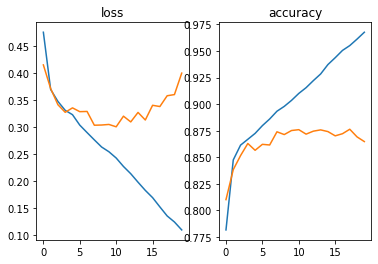

In [49]:
plt.subplot(1,2,1)
plt.title('loss')
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.subplot(1,2,2)
plt.title('accuracy')
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.show()

In [50]:
pre = model.predict(x_test5)

In [51]:
prex = np.mean(pre, axis=1)
pree = np.where(prex>0.5, 1, 0)

In [52]:
pree.shape

(25000,)

In [53]:
submission = pd.read_csv('/content/sampleSubmission.csv')

In [54]:
submission['sentiment'] = pree

In [55]:
submission.to_csv('submission.csv', index=False)

In [2]:
from gensim.models import Word2Vec, Phrases

In [5]:
a = ['and', 'of', 'boy', 'shot']
aa = Phrases(a)
aa['word of shot'.split()]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['word', 'of', 'shot']